# miniTri
miniTri is a proxy for a class of triangle based data analytics (Mantevo). This simple code is a self-contained piece of C++ software that uses triangle enumeration with a calculation of specific vertex and edge properties. Key uses related to miniTri include dense subgraph detection, characterizing graphs, improving community detection, and generating graphs. Related applications exist in cyber security, intelligence, and functional biology. miniTri attempts to be more application relevant than standard data analytics benchmarks such as Graph 500.

---
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-g -O3 -march=native -DNDEBUG -fopenmp -std=c++11'
Run_Parameters = 'enron. 10 [# Threads]'
```
file from http://graphchallenge.mit.edu/data-sets

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

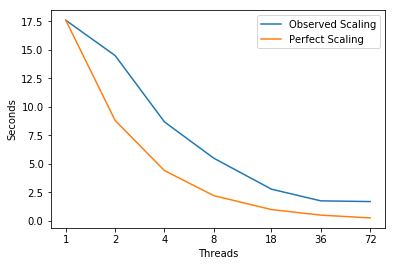

In [2]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[17.6, 14.5, 8.675, 5.4875, 2.7666666666666666, 1.7416666666666667, 1.6805555555555556],
        label='Observed Scaling')
ax.plot(Threads, [17.6, 8.8, 4.4, 2.2, 0.9777777777777779, 0.48888888888888893, 0.24444444444444446],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## addNZ( )
| addNZ() | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                                                                                                                                                                    |  67.5 %   |        1.2          |         1.7% |         70.6% |      9.9% |                0.45     |        3.5% |        3.3%  |       0.7%    |
| 72                                                                                                                                                                   |  65.7 %   |       0.45          |         1.6% |         67.0% |      0.0% |                0.13     |        2.0% |        1.8%  |       0.0%    |

```c++
627 int addNZ(std::map<int,std::list<int> > &nzMap,int col, int elemToAdd)
628 {
629   std::map<int,std::list<int> >::iterator it;
630 
631   it = nzMap.find(col);
632 
633   //////////////////////////////////////
634   //If columns match, no additional nz, add element to end of list
635   //////////////////////////////////////      
636   if(it != nzMap.end())
637   {
638     (*it).second.push_back(elemToAdd);
639     return 0;
640   }
641 
642   std::list<int> newList;
643   newList.push_back(elemToAdd);
644   nzMap.insert(std::pair<int,std::list<int> >(col, newList));
645   return 1;
646 }
```
|STL function | CPUTIME |
|:---|:---:|
| `insert()` | 26.6%|
| `push_back()` | 15.7% |
| `find()` | 9.4% |
| `list construction` | 9.6% |
| `list deconstruction` | 2.3%|

---
## computeKCounts
## 4.1% CPUTIME 
## -- 3.9% in loop at 671
| computeKCounts | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                |  1.7 %   |       0.79          |         9.8% |         44.6% |      0.0% |                0.16     |        5.4% |        3.2%  |       0.0%    |
| 72               |  4.2 %   |       0.18          |         4.4% |         65.0% |      0.0% |                0.06     |        1.7% |        1.5%  |       0.0%    |
```c++
      #pragma omp for schedule(dynamic,mBlockSize) 
669   for (int rownum=0; rownum<m; rownum++)
670   {
671     for(int nzIdx=0; nzIdx<nnzInRow[rownum]; nzIdx++)
672     {
673       int v1 = rownum;
674       int v2 = vals[rownum][nzIdx];
675       int v3 = vals2[rownum][nzIdx];
676 
677       // Removes redundant triangles
678       if(v1>v2 && v1>v3)
679       {
680 
681         /////////////////////////////////////////////////////////////////////////
682         // Find tvMin                                                  
683         /////////////////////////////////////////////////////////////////////////
684         unsigned int tvMin = std::min(std::min(vTriDegrees[v1],vTriDegrees[v2]),vTriDegrees[v3]);
685         /////////////////////////////////////////////////////////////////////////
686 
687         /////////////////////////////////////////////////////////////////////////
688         // Find teMin                                                            
689         /////////////////////////////////////////////////////////////////////////
690 
691         // I believe that v2<v3 by construction                                 
692         int e1,e2,e3;
693         if(v2<v3)
694         {
695           e1 = edgeInds.find(v2)->second.find(v3)->second;
696           e2 = edgeInds.find(v2)->second.find(v1)->second;
697           e3 = edgeInds.find(v3)->second.find(v1)->second;
698         }
699         else
700         {
701           e1 = edgeInds.find(v3)->second.find(v2)->second;
702           e2 = edgeInds.find(v3)->second.find(v1)->second;
703           e3 = edgeInds.find(v2)->second.find(v1)->second;
704         }
705 
706         unsigned int teMin = std::min(std::min(eTriDegrees[e1],eTriDegrees[e2]),eTriDegrees[e3]);
707         /////////////////////////////////////////////////////////////////////////
708 
709         /////////////////////////////////////////////////////////////////////////
710         // Determine k count for triangle                                        
711         /////////////////////////////////////////////////////////////////////////
712         unsigned int maxK=3;
713         for(unsigned int k=3; k<kCounts.size(); k++)
714         {
715           if(tvMin >= choose2(k-1) && teMin >= k-2)
716           {
717             maxK = k;
718           }
719           else
720           {
721             break;
722           }
723         }
724         localK[maxK]++;
725         /////////////////////////////////////////////////////////////////////////
726       }
727     }
728   } // end loop over rows                                 


```

Missing time largely allocating memory